In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import deepdish as dd
import csv
import random
import os
from scipy import io

from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F 
from sklearn.metrics import mean_squared_error

import torch.autograd
from torch.autograd import Variable
import torch.optim as optim
import math
from collections import namedtuple, deque
from scipy import stats

import gurobipy  as grb
from gurobipy import *
GRB = grb.GRB


In [2]:
files = os.listdir('D:\python\聚类Exploration\Baseline估计Integrate Way\CleanData')
#print(files)
print(len(files))

Dicblock0 = {}
for i in range(len(files)):
    Dicblock0[files[i]] = np.load("D:/python/聚类Exploration/Baseline估计Integrate Way/CleanData/" + files[i])

print('The number of users:', len(files))


with open('D:/python/Online Forecast/Elasticity Modelling/Acorn.csv') as csv_file:
    reader = csv.reader(csv_file)
    Acorn_info = dict(reader)
    
    
with open('D:/python/Online Forecast/Elasticity Modelling/ToU.csv') as csv_file:
    reader = csv.reader(csv_file)
    ToU_info = dict(reader)

df_tarrif = pd.read_csv("D:/python/Online Forecast/Elasticity Modelling/Tariffs.csv", encoding="utf-8")

1132
The number of users: 1132


In [3]:
lpvalueloss = io.loadmat('./lpvalueloss.mat')
Nregion = lpvalueloss['A'].shape[1]
print(Nregion)

7


In [42]:
print(42.42640687/0.70710678)

60.000000098994946


In [4]:
for i in range(Nregion):
    print(lpvalueloss['A'][0,i])
    print(lpvalueloss['b'][0,i])
    print(lpvalueloss['F'][0,i])
    print(lpvalueloss['g'][0,i])
    print()

[[ 1.          0.        ]
 [ 0.         -1.        ]
 [ 0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
[[70.        ]
 [ 0.        ]
 [42.42640687]
 [ 0.        ]]
[[ 7 18]]
[[0]]

[[-1.          0.        ]
 [ 1.          0.        ]
 [ 0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
[[-70.        ]
 [120.        ]
 [ 42.42640687]
 [  0.        ]]
[[12 18]]
[[-350]]

[[ 1.          0.        ]
 [ 0.         -1.        ]
 [-0.70710678  0.70710678]]
[[ 70.        ]
 [  0.        ]
 [-42.42640687]]
[[ 9 16]]
[[-120]]

[[-1.          0.        ]
 [ 1.          0.        ]
 [ 0.          1.        ]
 [-0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
[[  0.        ]
 [ 70.        ]
 [120.        ]
 [ 42.42640687]
 [  0.        ]]
[[-30  55]]
[[0]]

[[-1.          0.        ]
 [ 1.          0.        ]
 [ 0.         -1.        ]
 [-0.70710678  0.70710678]]
[[-70.        ]
 [120.        ]
 [  0.        ]
 [-42.42640687]]
[[14 16]]
[[-470]]

[[-1.          0.        ]
 [ 0.      

In [5]:
# 判断 Acorn_info, ToUInfo unique类别的个数 
def unique(Dic):
    lis = []
    for key,value in Dic.items():
        lis.append(value)
    #print(lis)
    df = pd.DataFrame(lis)
    return df[0].unique()

def CustomerDivisonTariff(ToU_info, ToUUnique,Dicblock0):
    
    ## 初始化
    TariffDic = {}
    TariffDicStdR = {}
    TariffDicToUR = {}
    
    TariffDicStdMAX = {}
    TariffDicToUMAX= {}
    
        
    for x in ToUUnique:
        TariffDic[x] = []
     
        
    ## 划分三个集合    
    for key,value in ToU_info.items():
        if value == 'Std':
            TariffDic['Std'].append(Dicblock0[key+'.npy'])
        else:
            TariffDic['ToU'].append(Dicblock0[key+'.npy'])
            
    print('Number of ToU users:',len(TariffDic['ToU']))
    print('Number of Std users:',len(TariffDic['Std']))
    
      
    
    s = 0
    for user in range(len(TariffDic['ToU'])):
        s += TariffDic['ToU'][user]
    
    sStd = 0
    for user in range(len(TariffDic['Std'])):
        sStd += TariffDic['Std'][user]
    
    
    
    
    return s+20



In [6]:
def load_normalization(load,hmin,hmax):
    
    load = load.reshape(-1)
    Xmin = np.min(load)
    Xmax = np.max(load)
    
    XR = (load-Xmin)/(Xmax-Xmin)
    
    print(np.min(XR*(hmax-hmin)+hmin),np.max(XR*(hmax-hmin)+hmin))
    
    return (XR*(hmax-hmin)+hmin).reshape(365,-1)

In [7]:
ToUUnique = unique(ToU_info)
TariffDicToUEst = CustomerDivisonTariff(ToU_info, ToUUnique,Dicblock0)
TariffDicToUEst = load_normalization(TariffDicToUEst[:,np.arange(0,48,2)],hmin = 55,hmax = 90)

Number of ToU users: 251
Number of Std users: 881
55.0 90.0


In [8]:
wind2012 = np.load('D:\python\Integrated Forecasting and Optimizing\Imbalance Example/clean data/wind2012.npy')
wind2012new = wind2012[:-23,:]

In [9]:
print(wind2012new.shape)

(8760, 5)


In [10]:
windpower = wind2012new[:,0].reshape(365,-1)*55

In [11]:
def PreProcessing(X,Xwind,H=24):

    X = X.reshape(-1,H)
    Y = X[3:,:]
    Xf = np.zeros((Y.shape[0]*H,4))
    
    for i in range(Y.shape[0]):
        for j in range(H):
            if j < 23:
                Xf[i*H+j,:] = np.array([X[i,j],X[i+1,j],X[i+1,j+1],X[i+2,j]])
            else:
                Xf[i*H+j,:] = np.array([X[i,j],X[i+1,j],X[i+2,0],X[i+2,j]])
            
#             if j < 23 & j>0:               
#                 Xf[i*H+j,:] = np.array([X[i,j],X[i+1,j],X[i+1,j+1],X[i+2,j],X[i+2,j-1]])
#             elif j == 23:
#                 Xf[i*H+j,:] = np.array([X[i,j],X[i+1,j],X[i+2,0],X[i+2,j],X[i+2,j-1]])
#             elif j == 0:
#                 Xf[i*H+j,:] = np.array([X[i,j],X[i+1,j],X[i+1,j+1],X[i+2,j],X[i+1,23]])
    
    trainsize = int(Y.shape[0]*0.8)*24
    
    Xwindnew = Xwind[3*H:,:]
    
    print(Xf.shape,Xwindnew.shape)
    
    #Xf = np.hstack((Xl,Xwind[3*H:,:]))
    
    Xmin = np.min(np.hstack((Xf,Xwindnew))[:trainsize,:],axis = 0)
    Xmax = np.max(np.hstack((Xf,Xwindnew))[:trainsize,:],axis = 0)
    
    Ymin = np.min(Y.reshape(-1)[:trainsize,])
    Ymax = np.max(Y.reshape(-1)[:trainsize,])
    
    XTrR = (np.hstack((Xf,Xwindnew))[:trainsize,:]-Xmin)/(Xmax-Xmin)
    XTeR = (np.hstack((Xf,Xwindnew))[trainsize:,:]-Xmin)/(Xmax-Xmin)
    
    YTrR = (Y.reshape(-1)[:trainsize,]-Ymin)/(Ymax-Ymin)
    YTeR = (Y.reshape(-1)[trainsize:,]-Ymin)/(Ymax-Ymin)

#     Xmin = np.min(Xf[:trainsize,:],axis = 0)
#     Xmax = np.max(Xf[:trainsize,:],axis = 0)
    
#     Ymin = np.min(Y.reshape(-1)[:trainsize,])
#     Ymax = np.max(Y.reshape(-1)[:trainsize,])
    
#     XTrR = (Xf[:trainsize,:]-Xmin)/(Xmax-Xmin)
#     XTeR = (Xf[trainsize:,:]-Xmin)/(Xmax-Xmin)
    
#     YTrR = (Y.reshape(-1)[:trainsize,]-Ymin)/(Ymax-Ymin)
#     YTeR = (Y.reshape(-1)[trainsize:,]-Ymin)/(Ymax-Ymin)
    
    
    
    return XTrR,XTeR,YTrR,YTeR,Y.reshape(-1)[:trainsize,],Y.reshape(-1)[trainsize:,],Ymin,Ymax


    


def DeProcessing(X,Xmin,Xmax):
    
    return (X)*(Xmax-Xmin)+Xmin

In [12]:
XTrR,XTeR,YTrR,YTeR,YTr,YTe,Ymin,Ymax = \
PreProcessing((TariffDicToUEst-windpower)*1.2,wind2012new[:,1:],H=24)

(8688, 4) (8688, 4)


In [13]:
print(XTrR.shape)

(6936, 8)


In [14]:

print(YTe.shape)
print(Ymin,Ymax)

(1752,)
1.365831972345083 105.16200108964941


In [15]:
# YTr = 1- YTr
# YTe = 1- YTe

In [16]:

BETA=0.3
Nweight = 8 # number of input features

In [17]:
def least_square(XTr,YTr,XTe,Nweight=Nweight):
    m=grb.Model("mse")
    weights = m.addVars(range(Nweight+1),lb = -GRB.INFINITY,vtype=GRB.CONTINUOUS)
    Llist = m.addVars(range(YTr.shape[0]),lb = 0,vtype=GRB.CONTINUOUS)
    #ypre = m.addVars(range(YloadTr.shape[0]),lb = 55,ub = 90,vtype=GRB.CONTINUOUS)
    ypre = []
    s = 0
    for i in range(YTr.shape[0]):
        
        ypre.append(Ymin+\
                    (Ymax-Ymin)*(sum([XTr[i,nw]*weights[nw] \
                                      for nw in range(Nweight)])+weights[Nweight]))
        s = s + (ypre[i]-YTr[i])*(ypre[i]-YTr[i])
    
    obj = s/YTr.shape[0]
    
    m.setObjective(obj, GRB.MINIMIZE)

    m.optimize() 
    
    weights = m.getAttr('x', weights)
    
    weights = weights.values()
    print(weights)
    
    
    ypreTr = []
    ypreTe = []
    for n in range(XTr.shape[0]):
        
        ypreTr.append(sum([XTr[n,nw]*weights[nw] for nw in range(Nweight)])\
                      +weights[Nweight])
            
#             XTr[n,0]*weights[0]+XTr[n,1]*weights[1]+XTr[n,2]*weights[2]+XTr[n,3]*weights[3]+weights[4])
    YTr_preO = DeProcessing(np.array(ypreTr),Ymin,Ymax)
    
    for n in range(XTe.shape[0]):
        
        ypreTe.append(sum([XTe[n,nw]*weights[nw] for nw in range(Nweight)])\
                      +weights[Nweight])
    YTe_preO = DeProcessing(np.array(ypreTe),Ymin,Ymax)
    
    return YTr_preO,YTe_preO
    

In [18]:
YTr_preOacc,YTe_preOacc = least_square(XTrR,YTr,XTeR)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-09
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 6945 columns and 0 nonzeros
Model fingerprint: 0xac642fe3
Model has 45 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [5e+03, 1e+04]
  QObjective range [5e+03, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 6936 columns
Presolve time: 0.01s
Presolved: 0 rows, 9 columns, 0 nonzeros
Presolved model has 45 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 17
 AA' NZ     : 2.800e+01
 Factor NZ  : 3.600e+01
 Factor Ops : 2.040e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective     

In [19]:
#def risk_neutral(XTr,YloadTr,YTr,XTe,YTe,YloadTe,N=N,Nregion = Nregion):
def risk_neutral(XTr,YTr,XTe,Nweight=Nweight,Nregion = Nregion):    
    
    m=grb.Model("neural")
    weights = m.addVars(range(Nweight+1),lb = -GRB.INFINITY,vtype=GRB.CONTINUOUS)
    Llist = m.addVars(range(YTr.shape[0]),lb = 0,vtype=GRB.CONTINUOUS)
    #ypre = m.addVars(range(YloadTr.shape[0]),lb = 55,ub = 90,vtype=GRB.CONTINUOUS)
    ypre = []
    s = 0
    for i in range(YTr.shape[0]):
        
        ypre.append(Ymin+\
                    (Ymax-Ymin)*(sum([XTr[i,nw]*weights[nw] \
                                      for nw in range(Nweight)])+weights[Nweight]))
            
        
        for j in range(Nregion):
            m.addConstr(Llist[i] >= (lpvalueloss['F'][0,j][0,0])*ypre[i]+\
                       lpvalueloss['F'][0,j][0,1]*YTr[i]+\
                        lpvalueloss['g'][0,j][0,0])
        s = s + Llist[i]
    obj = s/YTr.shape[0]
    
    m.setObjective(obj, GRB.MINIMIZE)

    m.optimize()   
    
    
    #weights = m.getAttr('x', weights)
    Llist = m.getAttr('x', Llist)
    weights = m.getAttr('x', weights)
    
    weights = weights.values()
    print(weights)
    
    
    ypreTr = []
    ypreTe = []
    for n in range(XTr.shape[0]):
        
        ypreTr.append(sum([XTr[n,nw]*weights[nw] for nw in range(Nweight)])\
                      +weights[Nweight])
            
#             XTr[n,0]*weights[0]+XTr[n,1]*weights[1]+XTr[n,2]*weights[2]+XTr[n,3]*weights[3]+weights[4])
    YTr_preO = DeProcessing(np.array(ypreTr),Ymin,Ymax)
    
    for n in range(XTe.shape[0]):
        
        ypreTe.append(sum([XTe[n,nw]*weights[nw] for nw in range(Nweight)])\
                      +weights[Nweight])
    YTe_preO = DeProcessing(np.array(ypreTe),Ymin,Ymax)
    
#     LlistTe = []
#     for i in range(XTe.shape[0]):   
#         for j in range(Nregion):
#             LlistTe.append(lpvalueloss['F'][0,j][0,0]*YTe_preO[i]*N+lpvalueloss['F'][0,j][0,1]*YloadTe[i]+\
#                        lpvalueloss['F'][0,j][0,2]*YTe[i]*N+lpvalueloss['g'][0,j][0,0])
#     print(np.mean(LlistTe))
    
    return YTe_preO,YTr_preO
    
    


In [20]:
YTe_preOneutral,YTr_preOneutral = risk_neutral(XTrR,YTr,XTeR)

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 48552 rows, 6945 columns and 485464 nonzeros
Model fingerprint: 0x39c1d8cf
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e-04, 1e-04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-03, 6e+03]
Presolve time: 0.33s
Presolved: 6945 rows, 48552 columns, 485464 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve time: 0.52s
Presolved: 6945 rows, 48552 columns, 485464 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.245e+04
 Factor NZ  : 6.975e+04 (roughly 23 MB of memory)
 Factor Ops : 7.070e+05 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal   

In [21]:
#def risk_aversion(XTr,YloadTr,YTr,XTe,YTe,YloadTe,BETA=BETA,N=N,Nregion = 3):
def risk_aversion(XTr,YTr,XTe,Nweight=Nweight,BETA=BETA,Nregion = Nregion): 
    
    m=grb.Model("aversion")
    weights = m.addVars(range(Nweight+1),lb = -GRB.INFINITY,vtype=GRB.CONTINUOUS)
    Llist = m.addVars(range(YTr.shape[0]),lb = 0,vtype=GRB.CONTINUOUS)
    alpha = m.addVar(lb = 0,vtype=GRB.CONTINUOUS)
    eta = m.addVars(range(YTr.shape[0]),lb = 0,vtype=GRB.CONTINUOUS)
    #ypre = m.addVars(range(YTr.shape[0]),lb = 55,ub = 90,vtype=GRB.CONTINUOUS)
    ypre = []
    s = 0
    for i in range(YTr.shape[0]):
        ypre.append(Ymin+\
                    (Ymax-Ymin)*(sum([XTr[i,nw]*weights[nw] \
                                      for nw in range(Nweight)])+weights[Nweight]))
        m.addConstr(eta[i] >= 0)
        
        for j in range(Nregion):
            m.addConstr(eta[i] >= (lpvalueloss['F'][0,j][0,0])*ypre[i]+\
                       lpvalueloss['F'][0,j][0,1]*YTr[i]+\
                        lpvalueloss['g'][0,j][0,0]-alpha)
        #m.addConstr(eta[i] >= Llist[i]-alpha)   
        s = s + eta[i]
    obj = alpha+s/(YTr.shape[0]*(1-BETA))
    
    m.setObjective(obj, GRB.MINIMIZE)

    m.optimize()   
    
#     ypre = m.getAttr('x', ypre)
#     print(alpha.x)
    
#     LlistTr = []
#     for i in range(YloadTr.shape[0]):   
#         listmax = []
#         for j in range(Nregion):
#             listmax.append(lpvalueloss['F'][0,j][0,0]*ypre[i]+\
#                        lpvalueloss['F'][0,j][0,1]*YloadTr[i]+lpvalueloss['g'][0,j][0,0])
#         LlistTr.append(max(listmax))
#     return ypre.values(),LlistTr
    

#     ypre = m.getAttr('x', ypre)
#     return ypre.values()
    
    Llist = m.getAttr('x', Llist)
    weights = m.getAttr('x', weights)
    
    weights = weights.values()
    print(weights)
    print(alpha.x)
    
    
    ypreTr = []
    ypreTe = []
    ypreTr = []
    ypreTe = []
    for n in range(XTr.shape[0]):
        
        ypreTr.append(sum([XTr[n,nw]*weights[nw] for nw in range(Nweight)])\
                      +weights[Nweight])
            
#             XTr[n,0]*weights[0]+XTr[n,1]*weights[1]+XTr[n,2]*weights[2]+XTr[n,3]*weights[3]+weights[4])
    YTr_preO = DeProcessing(np.array(ypreTr),Ymin,Ymax)
    
    for n in range(XTe.shape[0]):
        
        ypreTe.append(sum([XTe[n,nw]*weights[nw] for nw in range(Nweight)])\
                      +weights[Nweight])
    YTe_preO = DeProcessing(np.array(ypreTe),Ymin,Ymax)
    
#     LlistTe = []
#     for i in range(XTe.shape[0]):   
#         listmax = []
#         for j in range(Nregion):
#             listmax.append(lpvalueloss['F'][0,j][0,0]*YTe_preO[i]*N+lpvalueloss['F'][0,j][0,1]*YloadTe[i]+\
#                        lpvalueloss['F'][0,j][0,2]*YTe[i]*N+lpvalueloss['g'][0,j][0,0])
#         LlistTe.append(max(listmax))
    
    return YTe_preO,YTr_preO
    
    


In [22]:
%%time
YTe_preOaversion,YTr_preOaversion = \
risk_aversion(XTrR,YTr,XTeR)

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 55488 rows, 13882 columns and 540952 nonzeros
Model fingerprint: 0x8fb2249a
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-03, 6e+03]
Presolve removed 6936 rows and 6936 columns
Presolve time: 0.35s
Presolved: 6946 rows, 48552 columns, 534016 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.940e+04
 Factor NZ  : 7.669e+04 (roughly 23 MB of memory)
 Factor Ops : 8.534e+05 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0 

## Evaluation

In [23]:
def toy_decision(load,loadTr,cd1=18,cd2=16,cu1=55,cu2=60):
    
    m=grb.Model("toyDA")
    m.Params.LogToConsole = 0
    
    Pg1DA = m.addVar(vtype=GRB.CONTINUOUS)
    Pg2DA = m.addVar(vtype=GRB.CONTINUOUS)
    
    m.addConstr(Pg1DA <= 70)
    m.addConstr(-Pg1DA <= 0)
    
    m.addConstr(Pg2DA <= 70)
    m.addConstr(-Pg2DA <= 0)
    
    
    m.addConstr(Pg1DA + Pg2DA == load)
    
    obj = 25*Pg1DA + 30*Pg2DA
    
    m.setObjective(obj, GRB.MINIMIZE)
    m.update()
    m.optimize()
    
    m1=grb.Model("toyRT")
    m1.Params.LogToConsole = 0
    
    Pup1 = m1.addVar(lb = -GRB.INFINITY, vtype=GRB.CONTINUOUS)
    Pup2 = m1.addVar(lb = -GRB.INFINITY, vtype=GRB.CONTINUOUS)
    Pdown1 = m1.addVar(lb = -GRB.INFINITY, vtype=GRB.CONTINUOUS)
    Pdown2 = m1.addVar(lb = -GRB.INFINITY, vtype=GRB.CONTINUOUS)
    
    m1.addConstr(Pup1 <= 60)
    m1.addConstr(-Pup1 <= 0)
    
    m1.addConstr(Pup2 <= 60)
    m1.addConstr(-Pup2 <= 0)
    
    m1.addConstr(Pdown1 <= 60)
    m1.addConstr(-Pdown1 <= 0)
    
    m1.addConstr(Pdown2 <= 60)
    m1.addConstr(-Pdown2 <= 0)
        

    
    m1.addConstr(-Pdown1 - Pdown2 + Pup1 + Pup2 + load - loadTr == 0)
    
    
    obj = -cd1*Pdown1 - cd2*Pdown2 + cu1*Pup1 + cu2*Pup2
    
    m1.setObjective(obj, GRB.MINIMIZE)
    m1.update()
    m1.optimize()
    

    #print(Pup1.x,Pup2.x,Pdown1.x,Pdown2.x)
    
    shadow_priceRT = m1.getAttr('Pi', m1.getConstrs())

    
    return m.objVal,shadow_priceRT[-1],m1.objVal


In [24]:
toy_decision(load=10,loadTr=20)

(250.0, 55.0, 550.0)

In [25]:
toy_decision(load=20,loadTr=10)

(500.0, 18.0, -180.0)

In [26]:
def cost_acc(Ypre,Yload):
    cost = np.zeros((Yload.shape[0],))
    costDA = np.zeros((Yload.shape[0],))
    costRT = np.zeros((Yload.shape[0],))
    
    for i in range(Yload.shape[0]):
        costDA[i],_,costRT[i] = toy_decision(load = Ypre[i],loadTr = Yload[i])

        
        cost[i] = costDA[i] + costRT[i]
    print('min',np.min(cost))
    print('max',np.max(cost))
    print('mean',np.mean(cost))
    print('meanDA',np.mean(costDA))
    print('meanRT',np.mean(costRT))
    return np.mean(cost),cost

In [27]:
def cal_cvar(cost,BETA = BETA):
    costre = cost.reshape(-1)
    quantile = np.quantile(costre,BETA)
    print(quantile)
    #print(quantile)
    largecost = []
    for i in range(costre.shape[0]):
        if costre[i]> quantile:
            largecost.append(costre[i])
            
    print(np.mean(largecost))
    #return largecost

## Accuracy

Beta = 0.7

In [28]:
_,costaccTr = cost_acc(Ypre=YTr_preOacc,Yload=YTr)

min 125.77089743196152
max 3669.097670800525
mean 1718.8676674691392
meanDA 1449.771640824602
meanRT 269.0960266445371


In [29]:
_,costaccTe = cost_acc(Ypre=YTe_preOacc,Yload=YTe)

min 379.26281399198
max 3857.736616068906
mean 1879.9398052096021
meanDA 1480.6015668140599
meanRT 399.33823839554213


In [30]:
cal_cvar(costaccTr)

2120.617492267519
2499.912578836383


In [31]:
cal_cvar(costaccTe)

2242.5719762575973
2677.731992493126


Beta = 0.5

In [28]:
_,costaccTr = cost_acc(Ypre=YTr_preOacc,Yload=YTr)

min 125.77089743196152
max 3669.097670800525
mean 1718.8676674691392
meanDA 1449.771640824602
meanRT 269.0960266445371


In [29]:
_,costaccTe = cost_acc(Ypre=YTe_preOacc,Yload=YTe)

min 379.26281399198
max 3857.736616068906
mean 1879.9398052096021
meanDA 1480.6015668140599
meanRT 399.33823839554213


In [30]:
cal_cvar(costaccTr)

1752.165016807244
2277.6088289115796


In [31]:
cal_cvar(costaccTe)

1862.753245163379
2430.389454533581


Beta = 0.3

In [28]:
_,costaccTr = cost_acc(Ypre=YTr_preOacc,Yload=YTr)

min 125.77089743196152
max 3669.097670800525
mean 1718.8676674691392
meanDA 1449.771640824602
meanRT 269.0960266445371


In [29]:
_,costaccTe = cost_acc(Ypre=YTe_preOacc,Yload=YTe)

min 379.26281399198
max 3857.736616068906
mean 1879.9398052096021
meanDA 1480.6015668140599
meanRT 399.33823839554213


In [30]:
cal_cvar(costaccTr)

1321.8070071954307
2069.3557430732485


In [31]:
cal_cvar(costaccTe)

1493.5885417921895
2215.1215747241636


Beta = 0.2

In [ ]:
_,costaccTr = cost_acc(Ypre=YTr_preOacc,Yload=YTr)

In [ ]:
_,costaccTe = cost_acc(Ypre=YTe_preOacc,Yload=YTe)

In [ ]:
cal_cvar(costaccTr)

In [ ]:
cal_cvar(costaccTe)

Beta = 0.1

In [ ]:
_,costaccTr = cost_acc(Ypre=YTr_preOacc,Yload=YTr)

In [ ]:
_,costaccTe = cost_acc(Ypre=YTe_preOacc,Yload=YTe)

In [ ]:
cal_cvar(costaccTr)

In [ ]:
cal_cvar(costaccTe)

## Risk neutral

Beta = 0.7

In [32]:
_,costneutralTr = cost_acc(Ypre=YTr_preOneutral,Yload=YTr)

min 348.30231958895456
max 3334.491063536213
mean 1619.2509077448317
meanDA 1792.8466089737854
meanRT -173.59570122895352


In [33]:
_,costneutralTe = cost_acc(Ypre=YTe_preOneutral,Yload=YTe)

min 526.3891453181434
max 3351.501306022885
mean 1752.2939234067212
meanDA 1812.2653193488818
meanRT -59.971395942160385


In [34]:
cal_cvar(costneutralTr)

1883.0844958989658
2194.3376221848425


In [35]:
cal_cvar(costneutralTe)

1958.3491037418519
2362.1285326327225


Beta = 0.5

In [32]:
_,costneutralTr = cost_acc(Ypre=YTr_preOneutral,Yload=YTr)

min 348.30231958895456
max 3334.491063536213
mean 1619.2509077448317
meanDA 1792.8466089737854
meanRT -173.59570122895352


In [33]:
_,costneutralTe = cost_acc(Ypre=YTe_preOneutral,Yload=YTe)

min 526.3891453181434
max 3351.501306022885
mean 1752.2939234067212
meanDA 1812.2653193488818
meanRT -59.971395942160385


In [34]:
cal_cvar(costneutralTr)

1656.5523981905744
2023.1550160345978


In [35]:
cal_cvar(costneutralTe)

1717.23687199907
2151.8212255797425


Beta = 0.3

In [32]:
_,costneutralTr = cost_acc(Ypre=YTr_preOneutral,Yload=YTr)

min 348.30231958895456
max 3334.491063536213
mean 1619.2509077448317
meanDA 1792.8466089737854
meanRT -173.59570122895352


In [33]:
_,costneutralTe = cost_acc(Ypre=YTe_preOneutral,Yload=YTe)

min 526.3891453181434
max 3351.501306022885
mean 1752.2939234067212
meanDA 1812.2653193488818
meanRT -59.971395942160385


In [34]:
cal_cvar(costneutralTr)

1374.6347517774493
1880.17002419515


In [35]:
cal_cvar(costneutralTe)

1499.816857945393
1997.080167683186


Beta = 0.2

In [ ]:
_,costneutralTr = cost_acc(Ypre=YTr_preOneutral,Yload=YTr)

In [ ]:
_,costneutralTe = cost_acc(Ypre=YTe_preOneutral,Yload=YTe)

In [ ]:
cal_cvar(costneutralTr)

In [ ]:
cal_cvar(costneutralTe)

Beta = 0.1

In [ ]:
_,costneutralTr = cost_acc(Ypre=YTr_preOneutral,Yload=YTr)

In [ ]:
_,costneutralTe = cost_acc(Ypre=YTe_preOneutral,Yload=YTe)

In [ ]:
cal_cvar(costneutralTr)

In [ ]:
cal_cvar(costneutralTe)

## Risk aversion

Beta = 0.7

In [36]:
_,costaversionTr = cost_acc(Ypre=YTr_preOaversion,Yload=YTr)

min 559.4641817832662
max 3275.8713194707966
mean 1670.9145857094559
meanDA 2051.418254310006
meanRT -380.5036686005498


In [37]:
_,costaversionTe = cost_acc(Ypre=YTe_preOaversion,Yload=YTe)

min 703.6793382606254
max 3175.809949081569
mean 1785.214011002256
meanDA 2070.473605118867
meanRT -285.25959411661125


In [38]:
cal_cvar(costaversionTr)

1916.8856467684395
2130.434057452339


In [39]:
cal_cvar(costaversionTe)

1973.833705092487
2247.6332704910646


In [41]:
print((2362-2248)/2362)

0.04826418289585097


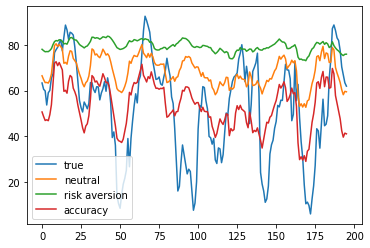

In [40]:
plt.plot(YTe[:196],label = 'true')
plt.plot(YTe_preOneutral[:196],label = 'neutral')
plt.plot(YTe_preOaversion[:196],label = 'risk aversion')
plt.plot(YTe_preOacc[:196],label = 'accuracy')
plt.legend()

Beta = 0.5

In [36]:
_,costaversionTr = cost_acc(Ypre=YTr_preOaversion,Yload=YTr)

min 477.4317806736469
max 3308.1427939888317
mean 1637.9813987097575
meanDA 1932.1164403181742
meanRT -294.13504160841677


In [37]:
_,costaversionTe = cost_acc(Ypre=YTe_preOaversion,Yload=YTe)

min 609.7514720824558
max 3237.4131462532514
mean 1761.5256002199817
meanDA 1952.1680455187982
meanRT -190.64244529881617


In [38]:
cal_cvar(costaversionTr)

1692.0667874688666
2000.3477615957088


In [39]:
cal_cvar(costaversionTe)

1754.596208415262
2110.9972261610837


In [40]:
print((2151-2111)/2151)

0.018596001859600187


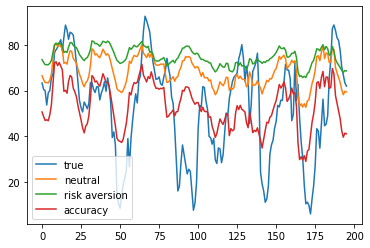

In [41]:
plt.plot(YTe[:196],label = 'true')
plt.plot(YTe_preOneutral[:196],label = 'neutral')
plt.plot(YTe_preOaversion[:196],label = 'risk aversion')
plt.plot(YTe_preOacc[:196],label = 'accuracy')
plt.legend()

Beta = 0.3

In [36]:
_,costaversionTr = cost_acc(Ypre=YTr_preOaversion,Yload=YTr)

min 429.33341557336985
max 3317.803873954137
mean 1624.9010741473248
meanDA 1863.7874860185123
meanRT -238.88641187118742


In [37]:
_,costaversionTe = cost_acc(Ypre=YTe_preOaversion,Yload=YTe)

min 571.8058021514362
max 3272.582133078169
mean 1753.7205914798255
meanDA 1884.6438881898614
meanRT -130.9232967100358


In [38]:
cal_cvar(costaversionTr)

1405.0177855473314
1873.0003221290785


In [39]:
cal_cvar(costaversionTe)

1524.9164683757147
1984.0617608796413


In [40]:
print((1997-1984)/1997)

0.006509764646970456


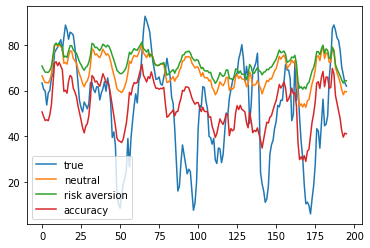

In [41]:
plt.plot(YTe[:196],label = 'true')
plt.plot(YTe_preOneutral[:196],label = 'neutral')
plt.plot(YTe_preOaversion[:196],label = 'risk aversion')
plt.plot(YTe_preOacc[:196],label = 'accuracy')
plt.legend()

Beta = 0.2

In [ ]:
_,costaversionTr = cost_acc(Ypre=YTr_preOaversion,Yload=YTr)

In [ ]:
_,costaversionTe = cost_acc(Ypre=YTe_preOaversion,Yload=YTe)

In [ ]:
cal_cvar(costaversionTr)

In [ ]:
cal_cvar(costaversionTe)

In [ ]:
print((1770-1756)/1770)

In [ ]:
plt.plot(YTe[:196],label = 'true')
plt.plot(YTe_preOneutral[:196],label = 'neutral')
plt.plot(YTe_preOaversion[:196],label = 'risk aversion')
plt.plot(YTe_preOacc[:196],label = 'accuracy')
plt.legend()

beta = 0.1

In [ ]:
_,costaversionTr = cost_acc(Ypre=YTr_preOaversion,Yload=YTr)

In [ ]:
_,costaversionTe = cost_acc(Ypre=YTe_preOaversion,Yload=YTe)

In [ ]:
cal_cvar(costaversionTr)

In [ ]:
cal_cvar(costaversionTe)

In [ ]:
print((1690-1684)/1690)

In [ ]:
plt.hist(costaversionTe)
plt.hist(costneutralTe)

In [ ]:
plt.plot(YTe[:196],label = 'true')
plt.plot(YTe_preOneutral[:196],label = 'neutral')
plt.plot(YTe_preOaversion[:196],label = 'risk aversion')
plt.plot(YTe_preOacc[:196],label = 'accuracy')
plt.legend()

In [41]:
np.savetxt('./resultsNetVPP/Beta3/YTe_preOneutral.txt',YTe_preOneutral)
np.savetxt('./resultsNetVPP/Beta3/YTe_preOaversion.txt',YTe_preOaversion)
np.savetxt('./resultsNetVPP/Beta3/YTr_preOneutral.txt',YTr_preOneutral)
np.savetxt('./resultsNetVPP/Beta3/YTr_preOaversion.txt',YTr_preOaversion)
np.savetxt('./resultsNetVPP/Beta3/costaversionTe.txt',costaversionTe)
np.savetxt('./resultsNetVPP/Beta3/costneutralTe.txt',costneutralTe)

In [47]:
np.savetxt('./resultsNetVPP/YTr_preOacc.txt',YTr_preOacc)
np.savetxt('./resultsNetVPP/YTe_preOacc.txt',YTe_preOacc)

In [48]:
np.savetxt('./resultsNetVPP/YTr.txt',YTr)
np.savetxt('./resultsNetVPP/YTe.txt',YTe)